In [ ]:
# Installation of FEniCS in Colab via
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

### Time dependent Stokes equation ###

Please carefully study the below code. Understand 

1. Mesh refinement
2. Discretization
3. Utilization of mixed spaces
4. Introduction of Lagrange multipliers

and try to extend this code to Navier-Stokes by introducing a term

$$
\int_\Omega (\vec{u}^{k-1}\cdot\nabla \vec{u}^{k-1})\cdot\vec{v}\,\mathrm{d}x
$$

in the weak formulation. The parameters should be set to create a vortex street after a couple of thousand iterations.

How could this code be optimized?

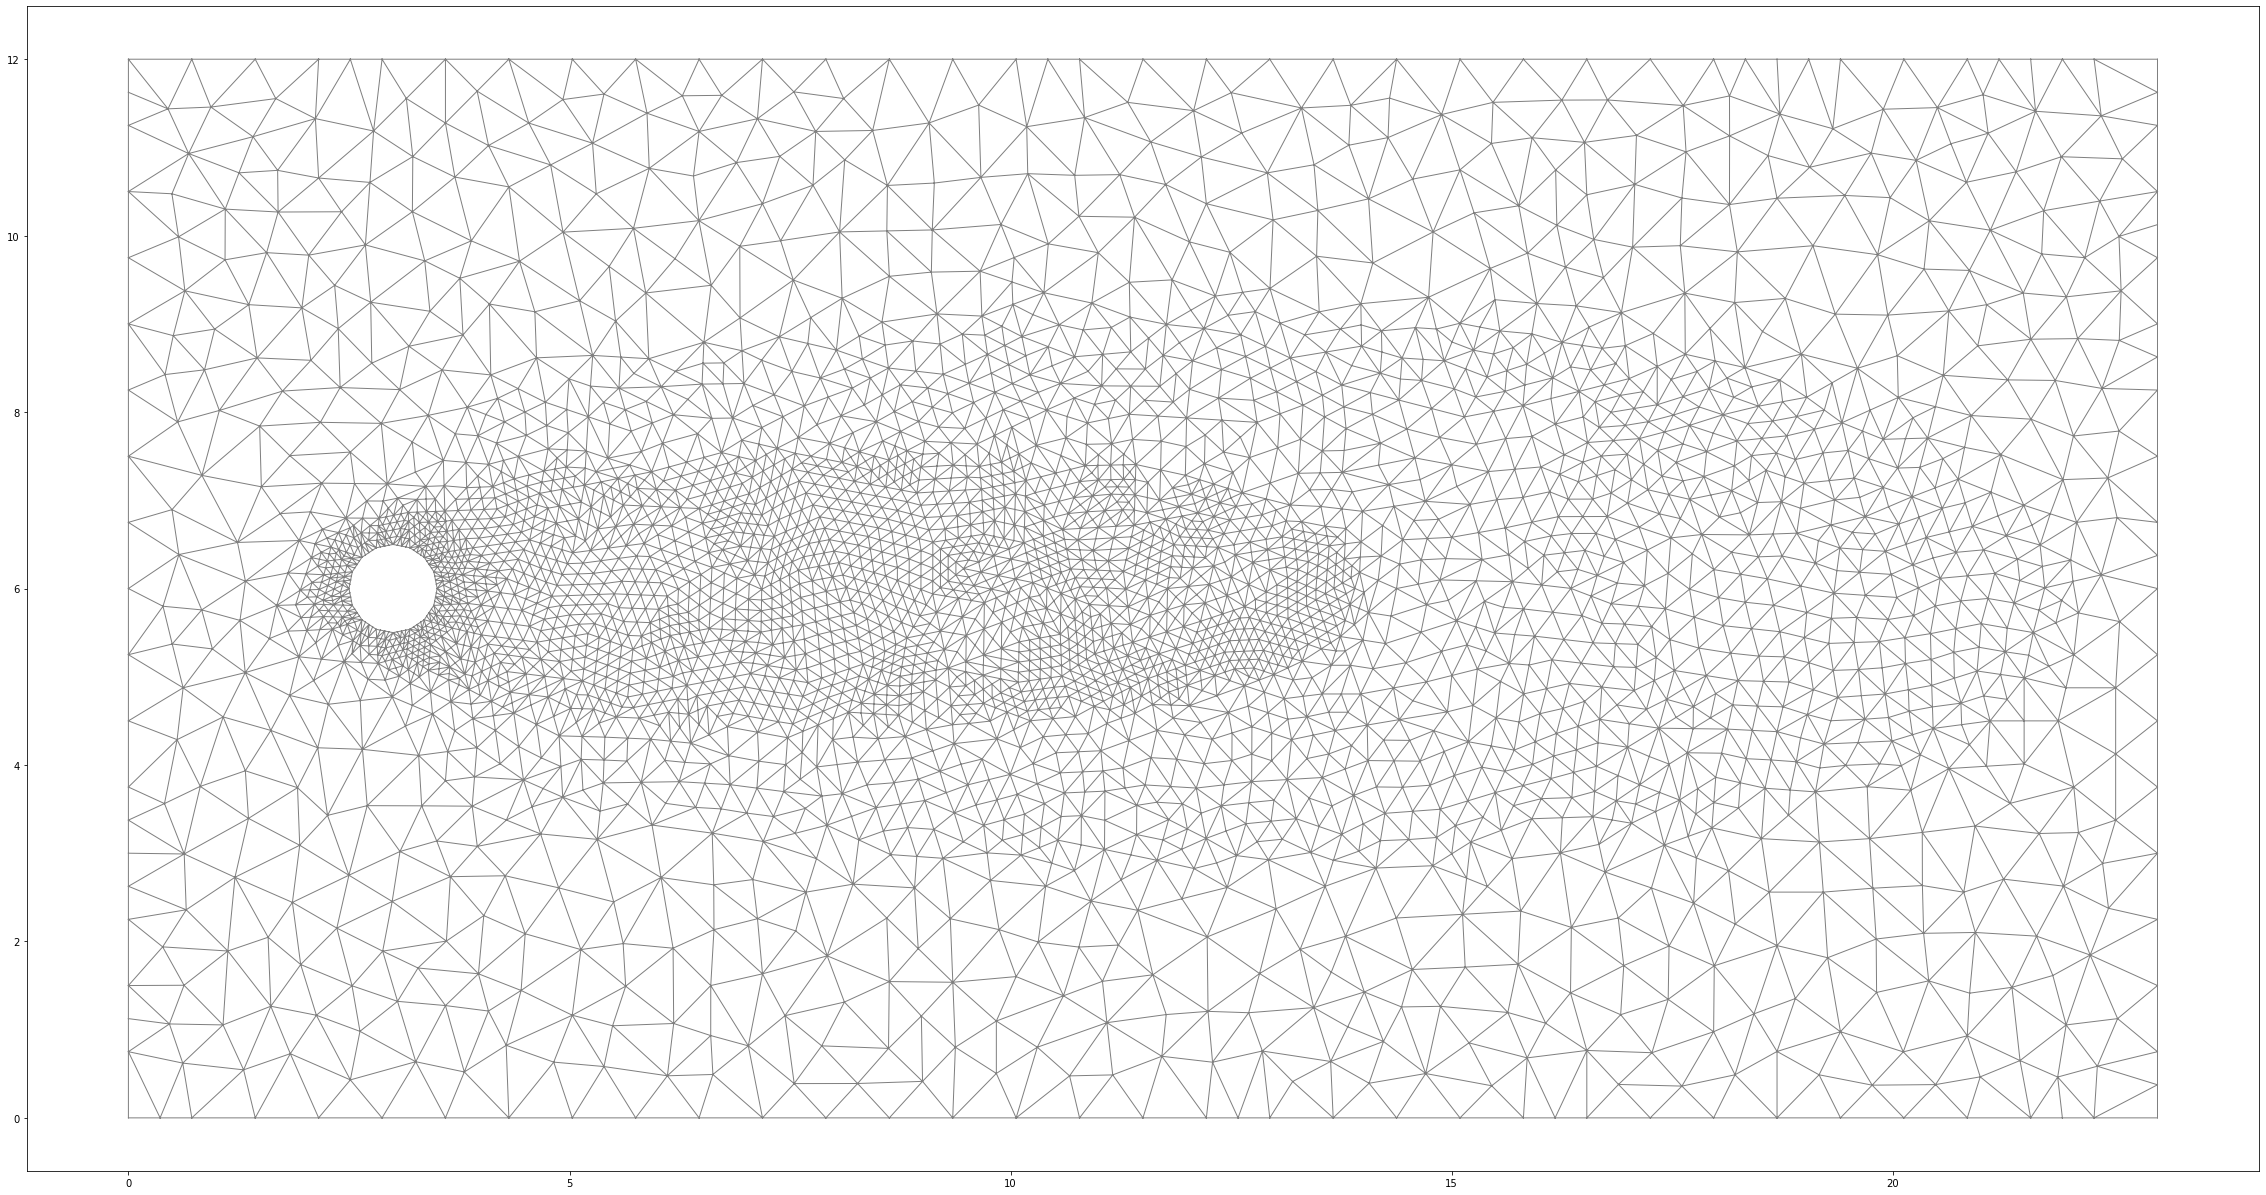

In [2]:
from fenics import *
from mshr import *
from pylab import plt
import numpy as np

# generate domains and meshes

L  = 23.0
H  = 12.0
X  = 3.0
r  = 0.5
nr = 16

rect   = Polygon([Point(0,0),Point(L,0),Point(L,H),Point(0,H)])
disc   = Circle(Point(X,H/2),r,nr)
domain = rect - disc
mesh   = generate_mesh(domain,24)

def create_markers(mesh,X0,xr,yr):
    cell_markers = MeshFunction("bool",mesh,mesh.geometric_dimension())
    for cell in cells(mesh):
        cell_index = cell.index()
        pos = np.reshape(cell.get_vertex_coordinates(),(-1,2))
        xm  = np.mean(pos[:,0])
        ym  = np.mean(pos[:,1])
        rr = ((xm-X0)**2)/(xr*xr) + ((ym-H/2)**2)/(yr*yr)
        if (rr < 1):
            cell_markers[cell_index] = True
        else:
            cell_markers[cell_index] = False
    return cell_markers


mesh = refine(mesh,create_markers(mesh,  12,   10.0, 3.0))
mesh = refine(mesh,create_markers(mesh,   8,    6.0, 1.5))
# mesh = refine(mesh,create_markers(mesh,   4,    2.0, 1.0))

plt.figure(figsize=(40,40))
plot(mesh,linewidth=1)

### From Stokes to Navier-Stokes ###

We solve the time-dependent Navier-Stokes equation and seek $q=(\vec{u},p)$, where the velocity field is $\vec{u}:[0,T]\times\Omega\to\mathbb{R}^d$ and the pressure is $p:[0,T]\times\Omega\to\mathbb{R}$. We discretize in time via $q^k=q(t^k)$ for given times $0=t_0<t_1<...<t_N=T$ and in space by seeking 
$q^k=(\vec{u}^k_h,p^k_h)$ such that $\vec{u}^k_h\in V^u_h$ and $p^k_h\in V^p_h$ for finite-dimensional functionspaces $V^u_h$ (vectorial) and $V^p_h$ (scalar). This results in the weak form of the Stokes problem,
where we seek $q=(\vec{u},p)$ such that

\begin{align}
\int_\Omega \partial_t \vec{u}\cdot\vec{v}\,\mathrm{d}x + a(q,r)=0
\end{align}

with

$$
a(q,r)=\int_\Omega \mu\nabla \vec{u}:\nabla\vec{v} + p \nabla\cdot\vec{v} + s \nabla\cdot\vec{u}\,\mathrm{d}x
$$

holds for all $r=(\vec{v},s)$. This problem is discretized in time via
\begin{align}
\int_\Omega \frac1\tau\left(\vec{u}^k-\vec{u}^{k-1}\right)\cdot\vec{v}\,\mathrm{d}x + a(q^k,r)=0,
\end{align}
and in space we use vectorial P2 elements for velocities and scalar P1 elements for the pressure (Taylor-Hood element).

In [ ]:
# FE definitions
P1   = FiniteElement("P", mesh.ufl_cell(), 1)    # scalar element
P2   = VectorElement("P", mesh.ufl_cell(), 2)    # vector element
V    = FunctionSpace(mesh,MixedElement([P2,P1])) # mixed space
parameters["form_compiler"]["quadrature_degree"] = 3

W1 = FunctionSpace(mesh,P1)
W2 = FunctionSpace(mesh,P2)

# Define Dirichlet boundary conditions
tol     = 1E-4
def boundary_dirichlet(x, on_boundary):
    return on_boundary and (near(x[1], 0, tol) or near(x[1], H, tol) or near(x[0], 0, tol))

def boundary_disc(x, on_boundary):
    r2 = (x[0]-X)**2 + (x[1]-H/2)**2
    return on_boundary  and near(r2,r*r,0.02)

ubc = Expression(("30.0","0"),H=H,degree=3)
bc1 = DirichletBC(V.sub(0), ubc, boundary_dirichlet)
bc2 = DirichletBC(V.sub(0), Constant((0.0,0.0)), boundary_disc)
bc  = [bc1,bc2]

# single time step
def evolve(old_q, tau):
    
    q,dq        = Function(V),TestFunction(V)
    u,p         = split(q)
    du,dp       = split(dq)
    old_u,old_p = split(old_q)
    
    dudt = (u - old_u)/tau
    
    Res  = inner(dudt,du)*dx + mu*inner(grad(u),grad(du))*dx
    Res += p*div(du)*dx + dp*div(u)*dx
    
    q.assign(old_q)
    solve(Res==0, q, bc) 
    
    return q
    
# main time loop
mu      =  0.2
n_steps =  5000
tau     =  0.001/4
t       =  0.0

old_q = interpolate(Expression(("0.0","0.0","0.0"),degree=2),V)
file_u  = File("lecture09_u.pvd")
file_p  = File("lecture09_p.pvd")
file_w  = File("lecture09_w.pvd")

for i in range(n_steps):
    print(i)
    t = t + tau
    q = evolve(old_q, tau)
    
    if ((i % 20)==0):
        u,p = split(q)
    
        op = project(p,W1)
        ou = project(u,W2)
        ow = project(u[1].dx(0)-u[0].dx(1),W1)
    
        ou.rename("u","")
        op.rename("p","")
        ow.rename("w","")

        file_u << (ou,t)
        file_p << (op,t)
        file_w << (ow,t)
    old_q.assign(q)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27